<a href="https://colab.research.google.com/github/myungju0130/myungju/blob/master/250627.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data

In [ ]:
# 필수 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 그래프 기본 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 텍스트 처리
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
# 머신러닝
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [ ]:
sample_submission=pd.read_csv('./data/sample_submission.csv')
sample_submission_stg2=pd.read_csv('./data/sample_submission_stg2.csv')
test=pd.read_csv('./data/test.tsv', sep="\t")
test_stg2=pd.read_csv('./data/test_stg2.tsv',sep="\t")
train=pd.read_csv('./data/train.tsv',sep="\t")

In [ ]:
sample_submission.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [ ]:
sample_submission_stg2.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [ ]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [ ]:
test_stg2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1.0,Women/Jewelry/Rings,NaN,1.0,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1.0,Other/Office supplies/Shipping Supplies,NaN,1.0,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1.0,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1.0,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2.0,Women/Sweaters/Cardigan,NaN,0.0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3.0,Other/Books/Religion & Spirituality,NaN,1.0,Rediscovering life after the loss of a loved o...


In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
#가설: 판매자가 적극적일수록(판매자의 신뢰도가 높을수록) 상품의 가격은 높을 것이다

#판매자가 적극적이다 = 판매자의 신뢰도가 높다

#다음 기준을 만족하기 위해서 새로 세운 기준
# 1) item_description의 글자 수를 계산하여 설명의 길이 구하기 > 정량화
# 2) item_description에 'authentic(정품)', 'new', 'NWT(New with tags)', 'mint condition(최상급 상태)' 등 긍정적/신뢰도 키워드가 몇 개나 포함되었는지 계산
# 3) 신뢰도 점수 새롭게 생성
    #중요도
    #가중치 > 정규화 스케일링 필요
    #corr

In [ ]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
train.isna().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,6327
brand_name,632682
price,0
shipping,0
item_description,6


In [ ]:
#가격이 0이면 삭제

zero_price_count = (train['price'] == 0).sum()
print(f"삭제 전, 가격이 0인 데이터 개수: {zero_price_count}")
print(f"삭제 전 전체 행 개수: {len(train)}")

train = train[train['price'] > 0].copy()

# 3. 삭제 후 결과 확인
print(f"\n삭제 후, 가격이 0인 데이터 개수: {(train['price'] == 0).sum()}") # 0이 나와야 함
print(f"삭제 후 전체 행 개수: {len(train)}")

삭제 전, 가격이 0인 데이터 개수: 874
삭제 전 전체 행 개수: 1482535

삭제 후, 가격이 0인 데이터 개수: 0
삭제 후 전체 행 개수: 1481661


In [ ]:
#결측치 사전 제거 > 카테고리 네임, 아이템 설명
columns_to_check = ['category_name', 'item_description']
train.dropna(subset=columns_to_check, inplace=True)

train.isna().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,628881
price,0
shipping,0
item_description,0


In [ ]:
condition_price_mean = train.groupby('item_condition_id')['price'].mean().sort_index()

print(condition_price_mean)

item_condition_id
1    26.505783
2    27.597665
3    26.554747
4    24.377497
5    31.781527
Name: price, dtype: float64


In [ ]:
condition_stats = train.groupby('item_condition_id')['price'].agg(['mean', 'median', 'count'])

print(condition_stats)

                        mean  median   count
item_condition_id                           
1                  26.505783    18.0  638026
2                  27.597665    17.0  373020
3                  26.554747    16.0  430137
4                  24.377497    15.0   31787
5                  31.781527    19.0    2371


In [ ]:
# 5등급 상품들만 필터링
condition_5_items = train[train['item_condition_id'] == 5]

# 가격이 높은 순으로 정렬하여 상위 20개 상품의 이름, 카테고리, 가격 확인
print(condition_5_items.sort_values(by='price', ascending=False)[['name', 'category_name', 'price']].head(20))

                                             name  \
1085244                           3x lg headphone   
761509                              iPhone 7 plus   
1158305                       Vuitton Brea GM Bag   
257978                           Cracked iPhone 7   
214560                     Antique Pocket Watches   
1318894                                 2 Watches   
126567                 Louis Vuitton neverfull MM   
983115    Apple Watches - 38mm - *For parts Only*   
814226             Apple MacBook Pro 13 inch 2010   
572079                    iPhone 7+ 128 Rose Gold   
277344                  7 TLC American Girl Dolls   
435406   Macbook pro mid 2012 FOR PARTS OR REPAIR   
100262    MacBook Pro 2012 13" (Please Read Info)   
463498                        Apple IPhone 6sPlus   
1450139             Water Damage Macbook Pro 2013   
421571        13" MacBook Pro with Retina Display   
528439                   Scrap or Repair 14k Gold   
1035823            MacBook Air READ DESCRIPTIO

In [ ]:
#item_condition_id: 1~5로 갈수록 상태가 좋지 않다
#단, 상태가 안 좋다고 해서 절대적인 가격 또한 낮아지는 것은 아니다
#오히려 고가의 상품 + 안 좋은 컨디션인 경우가 많다 (이상치)

#따라서, 절대적인 상품의 컨디션으로 봤을 땐 1 > 5 일수록 안 좋다
    #5인 경우, 고가의 부품 및 상품을 판매하여 상태는 좋지 않지만 높은 가격에 거래 (ex. 아이폰 부품용..)
    #고가 부품 시장 이라는 새로운 중고거래 시장이 있다..?

    #어떻게 처리해야 할 지 고민..

In [ ]:
train['brand_name'].nunique()

4789

In [ ]:
# brand_name 결측치 처리
train['is_brand'] = np.where(train['brand_name'].isna(), 0, 1) #0 > 아니다, 1 > 브랜드 O

print(train[['brand_name', 'is_brand']].head())

  brand_name  is_brand
0        NaN         0
1      Razer         1
2     Target         1
3        NaN         0
4        NaN         0


In [ ]:
#상품 설명 결측치 처리, 글자수 세기 (뛰어쓰기 포함)
count = (train['item_description'] == 'No description yet').sum()

print(count)

81807


In [ ]:
train['new_item_desc'] = train['item_description']

train['new_item_desc'] = train['new_item_desc'].replace('No description yet', np.nan)
train['new_item_desc'] = train['new_item_desc'].fillna('')

train['desc_len'] = train['new_item_desc'].str.len()

print(train[['item_description', 'new_item_desc', 'desc_len']].head(10))

                                    item_description  \
0                                 No description yet   
1  This keyboard is in great condition and works ...   
2  Adorable top with a hint of lace and a key hol...   
3  New with tags. Leather horses. Retail for [rm]...   
4          Complete with certificate of authenticity   
5  Banana republic bottoms, Candies skirt with ma...   
6  Size small but straps slightly shortened to fi...   
7  You get three pairs of Sophie cheer shorts siz...   
8   Girls Size small Plus green. Three shorts total.   
9  I realized his pants are on backwards after th...   

                                       new_item_desc  desc_len  
0                                                            0  
1  This keyboard is in great condition and works ...       188  
2  Adorable top with a hint of lace and a key hol...       124  
3  New with tags. Leather horses. Retail for [rm]...       173  
4          Complete with certificate of authenticity      

In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,is_brand,new_item_desc,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,0,,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1,This keyboard is in great condition and works ...,188
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1,Adorable top with a hint of lace and a key hol...,124
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,New with tags. Leather horses. Retail for [rm]...,173
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,0,Complete with certificate of authenticity,41


In [ ]:
train['category_name'].unique()

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ..., 'Handmade/Jewelry/Clothing',
       'Vintage & Collectibles/Supplies/Ephemera',
       'Handmade/Pets/Blanket'], dtype=object)

In [ ]:
#카테고리 분류

split_categories = train['category_name'].str.split('/', n=2, expand=True)

train['main_category'] = split_categories[0]
train['mid_category'] = split_categories[1]
train['sub_category'] = split_categories[2]

print(train[['category_name', 'main_category', 'mid_category', 'sub_category']].head(10))

                                       category_name           main_category  \
0                                  Men/Tops/T-shirts                     Men   
1  Electronics/Computers & Tablets/Components & P...             Electronics   
2                        Women/Tops & Blouses/Blouse                   Women   
3                 Home/Home Décor/Home Décor Accents                    Home   
4                            Women/Jewelry/Necklaces                   Women   
5                                  Women/Other/Other                   Women   
6                           Women/Swimwear/Two-Piece                   Women   
7                    Sports & Outdoors/Apparel/Girls       Sports & Outdoors   
8                    Sports & Outdoors/Apparel/Girls       Sports & Outdoors   
9           Vintage & Collectibles/Collectibles/Doll  Vintage & Collectibles   

          mid_category        sub_category  
0                 Tops            T-shirts  
1  Computers & Tablets  Compo

In [ ]:
train['main_category'].unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'Handmade'],
      dtype=object)

In [ ]:
train['mid_category'].unique()

array(['Tops', 'Computers & Tablets', 'Tops & Blouses', 'Home Décor',
       'Jewelry', 'Other', 'Swimwear', 'Apparel', 'Collectibles',
       'Makeup', 'Fragrance', 'Dresses', 'Office supplies', 'Shoes',
       'Gear', 'Athletic Apparel', 'Cell Phones & Accessories', 'Jeans',
       'Underwear', 'Skin Care', 'Toys', "Women's Handbags",
       'Video Games & Consoles', 'Coats & Jackets', 'Pants', 'Girls (4+)',
       'Antique', 'Kitchen & Dining', 'Sweaters', 'Boys 0-24 Mos',
       'Girls 0-24 Mos', 'Maternity', 'Bedding', 'Exercise',
       'Trading Cards', 'Boys (4+)', 'Storage & Organization', 'Fan Shop',
       'Girls 2T-5T', "Men's Accessories", 'Boys 2T-5T',
       "Women's Accessories", 'Daily & Travel items', 'Skirts',
       'Hair Care', 'Pet Supplies', 'Book', 'Tools & Accessories',
       'Team Sports', 'Home Appliances', 'Accessories', 'Bags and Purses',
       'Sweats & Hoodies', 'Shorts', 'TV, Audio & Surveillance',
       'Outdoors', 'Bath & Body', 'Car Seats & Accessor

In [ ]:
train['main_category'].value_counts()

,count
main_category,
Women,663987
Beauty,207724
Kids,171554
Electronics,122631
Men,93609
Home,67831
Vintage & Collectibles,46519
Other,45329
Handmade,30835


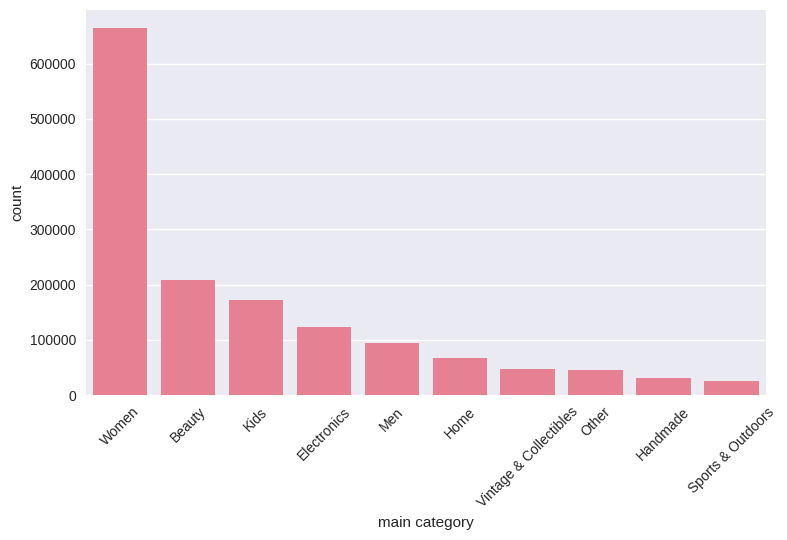

In [ ]:
main_category_counts= train['main_category'].value_counts()

sns.barplot(x=main_category_counts.index, y=main_category_counts.values)

plt.xlabel('main category')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
crosstab_df = pd.crosstab(train['main_category'], train['shipping'])

crosstab_normalized = crosstab_df.div(crosstab_df.sum(axis=1), axis=0)

print(crosstab_normalized)

shipping                       0         1
main_category                             
Beauty                  0.390263  0.609737
Electronics             0.415776  0.584224
Handmade                0.387871  0.612129
Home                    0.715307  0.284693
Kids                    0.590759  0.409241
Men                     0.656475  0.343525
Other                   0.463986  0.536014
Sports & Outdoors       0.557302  0.442698
Vintage & Collectibles  0.442077  0.557923
Women                   0.608172  0.391828


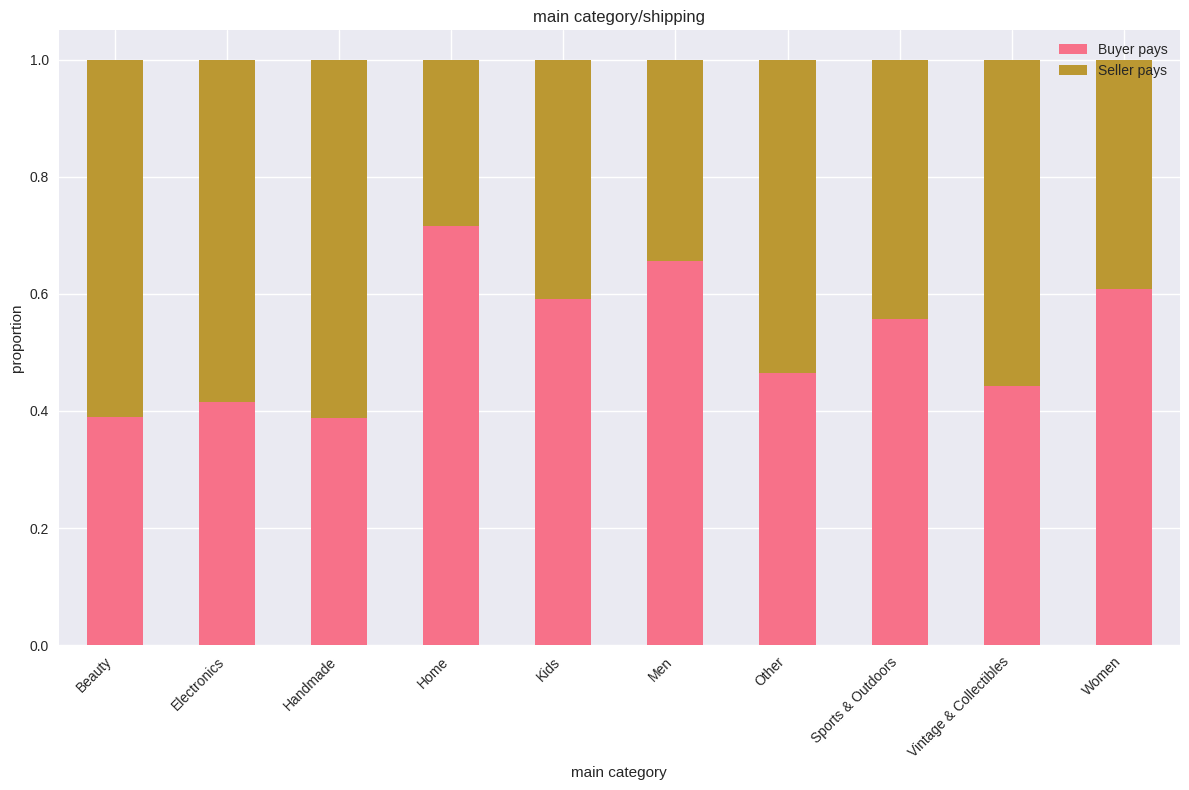

In [ ]:
ax = crosstab_normalized.plot(
    kind='bar',          # 막대그래프
    stacked=True,        # 누적 형태로
    figsize=(12, 8)      # 그래프 크기
)


plt.title('main category/shipping')
plt.xlabel('main category')
plt.ylabel('proportion')
plt.xticks(rotation=45, ha='right') # x축 레이블 회전

ax.legend(['Buyer pays', 'Seller pays'])
plt.tight_layout()
plt.show()

In [ ]:
# 키워드 리스트 > 신뢰도
# 대소문자 구분 X
keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']
keyword_pattern = '|'.join(keyword_list)

train['keyword_count'] = train['item_description'].str.lower().str.count(keyword_pattern)

print(train[['item_description', 'keyword_count']].sort_values(by='keyword_count', ascending=False).head())

#상품을 강조하고 검색에 잘 노출시키기 위해, 신뢰도를 주는 키워드들을 설명에 의도적으로 반복해서 많이 사용하는 '키워드 스터핑(Keyword Stuffing)' 전략

#키워드를 많이 사용한 상품들이 실제로도 평균보다 높은 가격에 팔리는가

                                         item_description  keyword_count
196308  Welcome! This is a bundle of crafts supplies d...             19
276784  Bin Pickers from YT wholesale lot #60. All kid...             19
391340  FREE SHIP BUNDLE INCLUDES EVERYTHING IN PICS- ...             18
608086  Bella Pierre loose mineral blush in the shade ...             15
476923  Outgrown Baby Bundle I Have These Things That ...             15


In [ ]:
#전체 상품 설명에서 가장 많이 사용된 단어 상위 20개

from collections import Counter
import re

all_descriptions = train['item_description'].str.cat(sep=' ')

all_words = re.findall(r'\b\w+\b', all_descriptions.lower())

stop_words = set(['rm', 'and', 'the', 'to', 'a', 'in', 'for', 'is', 'of', 'i', 'it', 'you', 'with', 'on', 'this', 'be', 'my', 'that', 'are'])
filtered_words = [word for word in all_words if word not in stop_words]

word_counts = Counter(filtered_words)

print("전체 상품 설명에서 가장 많이 사용된 단어 상위 20개")
print(word_counts.most_common(20))

전체 상품 설명에서 가장 많이 사용된 단어 상위 20개
[('new', 497927), ('size', 454425), ('no', 325355), ('brand', 273471), ('free', 270397), ('condition', 254961), ('shipping', 226362), ('s', 222843), ('or', 209067), ('2', 189812), ('worn', 186349), ('used', 183416), ('1', 182223), ('all', 163367), ('will', 160631), ('never', 158508), ('great', 153867), ('but', 153285), ('black', 152968), ('price', 150747)]


In [ ]:
#상위 5개 카테고리별 키워드 사용 빈도 분석

top_5_categories = train['main_category'].value_counts().head(5).index.tolist()
print(top_5_categories)

['Women', 'Beauty', 'Kids', 'Electronics', 'Men']


상위 5개 카테고리별 키워드 사용 빈도
               count_authentic  count_new  count_nwt  count_mint  \
main_category                                                      
Beauty                   28824     110080        956        2489   
Electronics               2809      47294        254         998   
Kids                      2089      48460       4018        2045   
Men                       5761      29691       1541         292   
Women                    22422     197448      34835        3851   

               count_sealed  count_perfect  count_excellent  
main_category                                                
Beauty                12808          12299             1269  
Electronics            5070           9875             3320  
Kids                   1672           7029             8298  
Men                     111           2937             3645  
Women                   695          41772            25794  


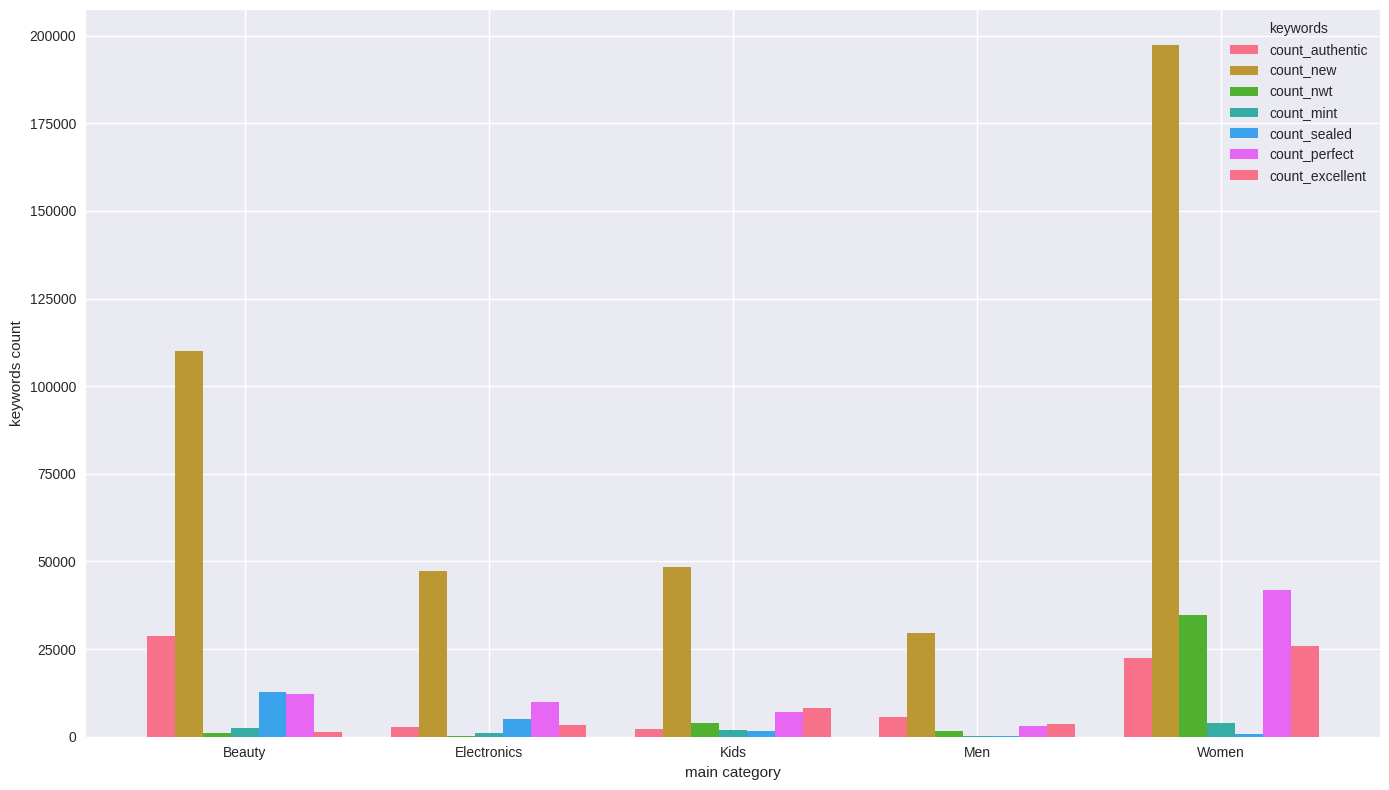

In [ ]:
keyword_list = ['authentic', 'new', 'nwt', 'mint', 'sealed', 'perfect', 'excellent']

top_categories_df = train[train['main_category'].isin(top_5_categories)].copy()

# 각 키워드별로 사용 횟수를 계산하여 새로운 컬럼으로 추가
for keyword in keyword_list:
    top_categories_df[f'count_{keyword}'] = top_categories_df['item_description'].str.lower().str.count(keyword)

# 'main_category'로 그룹화하고, 각 키워드 카운트의 합계를 계산
keyword_by_category = top_categories_df.groupby('main_category')[[f'count_{keyword}' for keyword in keyword_list]].sum()

print("상위 5개 카테고리별 키워드 사용 빈도")
print(keyword_by_category)



keyword_by_category.plot(
    kind='bar',
    figsize=(14, 8),
    width=0.8 # 막대 너비
)

plt.xlabel('main category')
plt.ylabel('keywords count')
plt.xticks(rotation=0)
plt.legend(title='keywords')
plt.tight_layout()
plt.show()

In [ ]:
#상위 5개 카테고리별 가장 많이 사용된 단어 (상위 10개)

stop_words = set(['rm', 'and', 'the', 'to', 'a', 'in', 'for', 'is', 'of', 'i', 'it', 'you', 'with', 'on', 'this', 'be', 'my', 'that', 'are', 'shipping', 'free', 'price'])

for category in top_5_categories:
    category_df = train[train['main_category'] == category]

    all_descriptions = category_df['item_description'].str.cat(sep=' ')

    all_words = re.findall(r'\b\w+\b', all_descriptions.lower())
    filtered_words = [word for word in all_words if word not in stop_words]

    word_counts = Counter(filtered_words)
    print(f"'{category}' 카테고리에서 가장 많이 사용된 단어 상위 10개:")
    print(word_counts.most_common(10))

'Women' 카테고리에서 가장 많이 사용된 단어 상위 10개:
[('size', 290394), ('new', 196320), ('no', 156472), ('worn', 144029), ('condition', 133421), ('s', 116862), ('brand', 105348), ('black', 92611), ('or', 84574), ('small', 82319)]
'Beauty' 카테고리에서 가장 많이 사용된 단어 상위 10개:
[('new', 108594), ('brand', 63856), ('used', 57224), ('1', 52870), ('no', 38641), ('2', 38391), ('all', 36696), ('never', 35391), ('or', 33175), ('3', 32942)]
'Kids' 카테고리에서 가장 많이 사용된 단어 상위 10개:
[('size', 59065), ('new', 45756), ('condition', 42586), ('no', 37571), ('brand', 24194), ('2', 23055), ('3', 21404), ('s', 21352), ('all', 20747), ('great', 19969)]
'Electronics' 카테고리에서 가장 많이 사용된 단어 상위 10개:
[('iphone', 54595), ('new', 46116), ('case', 39824), ('6', 28665), ('no', 27359), ('2', 26244), ('brand', 26087), ('your', 24725), ('phone', 23811), ('1', 22506)]
'Men' 카테고리에서 가장 많이 사용된 단어 상위 10개:
[('size', 40907), ('new', 29446), ('s', 25877), ('condition', 24748), ('no', 21747), ('men', 20525), ('worn', 17669), ('brand', 15819), ('great', 11871

In [ ]:
#상관분석

numeric_features = [
    'price',
    'item_condition_id',
    'shipping',
    'is_brand', # has_brand와 동일
    'desc_len',
    'keyword_count'
]

corr_df = train[numeric_features]

corr_matrix = corr_df.corr()
print(corr_matrix)


                      price  item_condition_id  shipping  is_brand  desc_len  \
price              1.000000          -0.000816 -0.097366  0.125550  0.048503   
item_condition_id -0.000816           1.000000 -0.191276  0.163130 -0.133500   
shipping          -0.097366          -0.191276  1.000000 -0.136506  0.111343   
is_brand           0.125550           0.163130 -0.136506  1.000000 -0.118424   
desc_len           0.048503          -0.133500  0.111343 -0.118424  1.000000   
keyword_count      0.105066          -0.356039  0.078204  0.002077  0.308677   

                   keyword_count  
price                   0.105066  
item_condition_id      -0.356039  
shipping                0.078204  
is_brand                0.002077  
desc_len                0.308677  
keyword_count           1.000000  


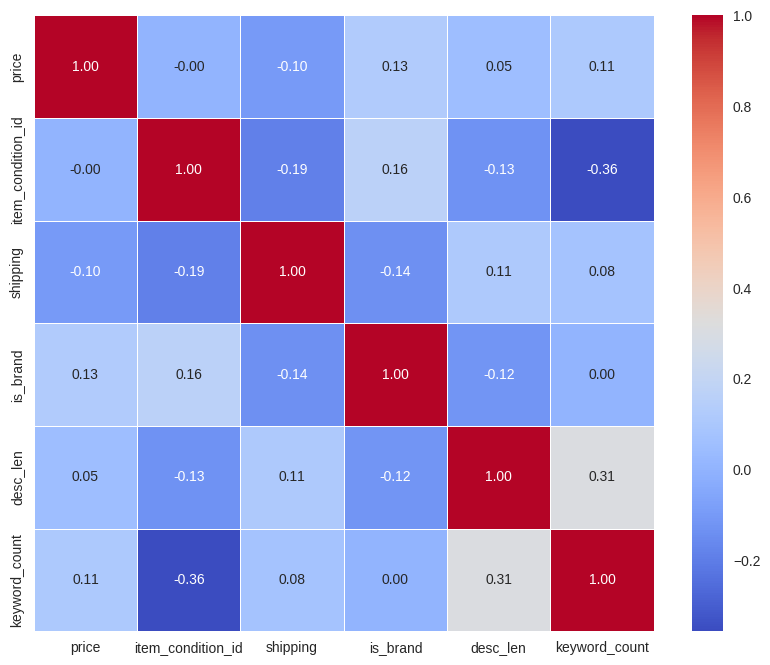

In [ ]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,      # 각 셀에 숫자 표시
    cmap='coolwarm', # 색상 테마 (양수는 따뜻한 색, 음수는 차가운 색)
    fmt='.2f',       # 숫자를 소수점 둘째 자리까지 표시
    linewidths=.5     # 셀 사이의 간격
)
plt.show()

In [ ]:
#정규화

from sklearn.preprocessing import MinMaxScaler

features_to_normalize = ['desc_len', 'keyword_count', 'item_condition_id']
scaler = MinMaxScaler()

for feature in features_to_normalize:
    train[f'{feature}_norm'] = scaler.fit_transform(train[[feature]])


#원핫인코딩 > 카테고리 대분류
main_category_dummies = pd.get_dummies(train['main_category'], prefix='category')
train_processed = pd.concat([train, main_category_dummies], axis=1)

#병합
final_features_list = [
    'item_condition_id_norm',
    'desc_len_norm',
    'keyword_count_norm',
    'shipping',
    'is_brand'
] + list(main_category_dummies.columns)

final_df = train_processed[final_features_list]
print(final_df.head())

   item_condition_id_norm  desc_len_norm  keyword_count_norm  shipping  \
0                     0.5       0.000000            0.000000         1   
1                     0.5       0.179732            0.052632         0   
2                     0.0       0.118547            0.000000         1   
3                     0.0       0.165392            0.052632         1   
4                     0.0       0.039197            0.052632         0   

   is_brand  category_Beauty  category_Electronics  category_Handmade  \
0         0            False                 False              False   
1         1            False                  True              False   
2         1            False                 False              False   
3         0            False                 False              False   
4         0            False                 False              False   

   category_Home  category_Kids  category_Men  category_Other  \
0          False          False          True      

In [ ]:
#상관관게 기반 가중치, 최종 신뢰도 점수 계산

score_features = [
    'item_condition_id_norm',
    'keyword_count_norm',
    'desc_len_norm',
    'shipping',
    'is_brand' # has_brand와 동일
]


correlations = train_processed[score_features].corrwith(np.log1p(train_processed['price']))

abs_correlations = correlations.abs()

weights = abs_correlations / abs_correlations.sum()
print(weights)


#신뢰도 점수 계싼
train_processed['credibility_score'] = (
    (1 - train_processed['item_condition_id_norm']) * weights.get('item_condition_id_norm', 0) +
    train_processed['keyword_count_norm'] * weights.get('keyword_count_norm', 0) +
    train_processed['desc_len_norm'] * weights.get('desc_len_norm', 0) +
    train_processed['shipping'] * weights.get('shipping', 0) +
    train_processed['is_brand'] * weights.get('is_brand', 0)
)

print(train_processed[['price', 'credibility_score']].head())

final_df['credibility_score'] = train_processed['credibility_score']
print(final_df.head())

item_condition_id_norm    0.003251
keyword_count_norm        0.232411
desc_len_norm             0.050612
shipping                  0.377315
is_brand                  0.336411
dtype: float64
   price  credibility_score
0   10.0           0.378940
1   52.0           0.359365
2   10.0           0.722977
3   35.0           0.401169
4   44.0           0.017467
   item_condition_id_norm  desc_len_norm  keyword_count_norm  shipping  \
0                     0.5       0.000000            0.000000         1   
1                     0.5       0.179732            0.052632         0   
2                     0.0       0.118547            0.000000         1   
3                     0.0       0.165392            0.052632         1   
4                     0.0       0.039197            0.052632         0   

   is_brand  category_Beauty  category_Electronics  category_Handmade  \
0         0            False                 False              False   
1         1            False                  True 

In [ ]:
#다중공선성 확인

from statsmodels.stats.outliers_influence import variance_inflation_factor

features_for_vif = train[[
    'item_condition_id_norm',
    'keyword_count_norm',
    'desc_len_norm',
    'shipping',
    'is_brand'
]].copy() # .copy()를 사용하여 경고 메시지 방지


features_for_vif.dropna(inplace=True)

features_for_vif['intercept'] = 1

vif = pd.DataFrame()
vif["Variable"] = [col for col in features_for_vif.columns if col != 'intercept'] # intercept 제외
vif["VIF"] = [variance_inflation_factor(features_for_vif.drop('intercept', axis=1).values, i) for i in range(features_for_vif.shape[1] - 1)]
print(vif)

                 Variable       VIF
0  item_condition_id_norm  1.730305
1      keyword_count_norm  1.710159
2           desc_len_norm  1.750286
3                shipping  1.502183
4                is_brand  1.964656


MSE: 0.4576


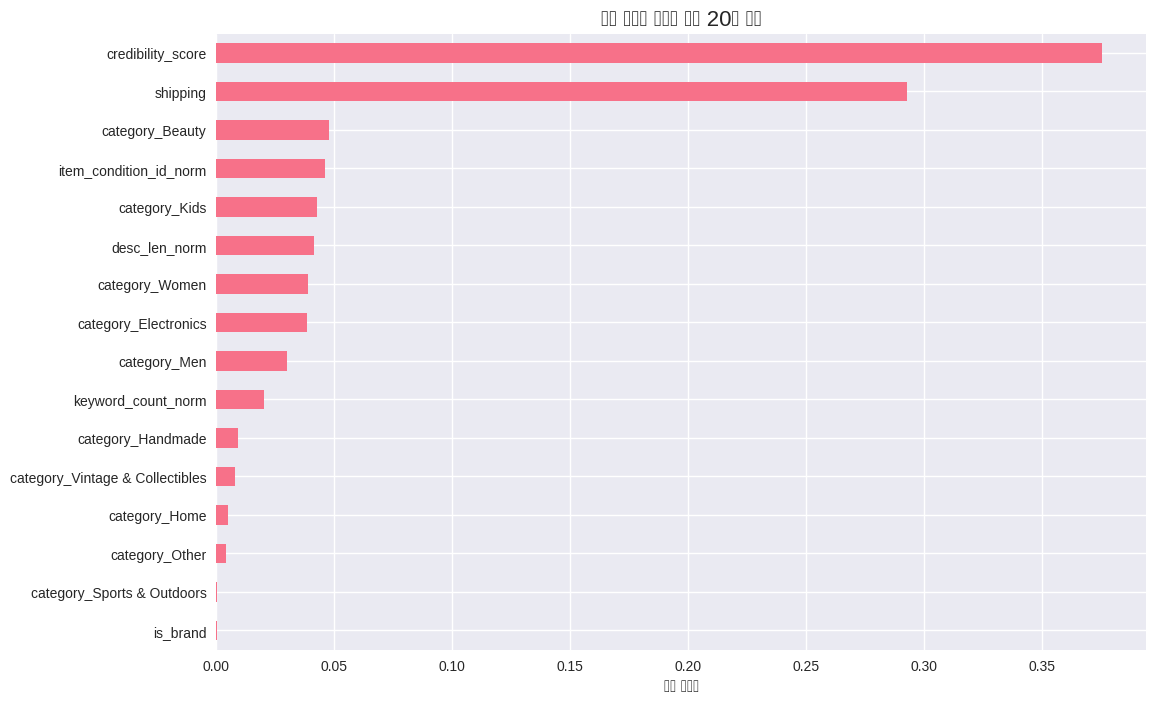

In [ ]:
#예측모델

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = final_df
y = np.log1p(train_processed['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse:.4f}")

#변수 중요도 추출
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# 상위 20개, 중요도 순으로 정렬
plt.figure(figsize=(12, 8))
feature_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh') # 보기 좋게 정렬
plt.title('가격 예측에 중요한 상위 20개 변수', fontsize=16)
plt.xlabel('피처 중요도', fontsize=12)
plt.show()

In [ ]:
#각 카테고리에 어떤 항목에서 높은 점수를 받았는가
#어떤 카테고리가 신뢰도가 높은지 근거

# 1. main_category로 그룹화하여, 신뢰도 점수와 그 구성요소들의 평균을 한 번에 계산
category_profile = train_cleaned.groupby('main_category').agg(
    avg_credibility_score=('credibility_score_final', 'mean'), # 최종 평균 점수
    shipping_rate=('shipping', 'mean'),                     # 판매자 배송비 부담 비율
    brand_rate=('is_brand', 'mean'),                        # 브랜드 보유 상품 비율
    avg_keyword_count=('keyword_count', 'mean'),            # 평균 키워드 개수
    avg_desc_len=('desc_len', 'mean'),                      # 평균 설명 길이
    avg_condition=('item_condition_id', 'mean'),            # 평균 상품 상태
    item_count=('price', 'size')                            # 해당 카테고리의 상품 개수
)


final_category_profile = category_profile.sort_values(by='avg_credibility_score', ascending=False)
print(final_category_profile)

NameError: name 'train_cleaned' is not defined

In [ ]:
#배송비가 가장 중요한 변수였다 (가중치: 37.7%)
  #무료배송은 가격과 강한 연관성을 가진다
  #판매자는 배송비를 미리 가격에 포함시키는 것이 좋음

#브랜드가치 (가중치: 33,6%)
  #상품 자체가 가진 본질적인 가치 (브랜드 유무)는 가격에 큰 영향을 미친다

#키워드는 (가중치: 23.3%)
  #신뢰도 키워드는 판매자들이 상품 가치를 높이는 전략이 가격에 반영되고 있음

#상품 설명 길이, 상품 상태는 위 요인에 비해서는 영향력이 적다
  #다중공선성으로 상품 상태가 영향력이 낮을 것이다(추측) > 상품상태가 가격에 미치는 영향력은 다중공선성 문제가 아닌 애초부터 적은 값
  #상품 상태는 키워드 등에 반영이 되었을 것이다 > 상품 상태는 가격에 미치는 영향보다 무료배송여부, 키워드 사용과 같은 판매자의 적극성이 더 중요하다

  #또는, 상품 상태와 가격이 선형 관계가 아니기 때문에 (5등급) 평균 가격이 크게 작용하지 않았을수도



#가설: 판매자의 적극성이 높을수록 가격이 높을 것이다
  #판매자의 적극성을 알기 위해 상품상태, 설명길이, 키워드 사용, 배송비 부담, 브랜드 유무로 신뢰도 점수를 만듦

# 1. 판매자가 직접 선택하는 배송비 부담 여부, 키워드 사용은 가격에 큰 영향을 미친다
  #판매자의 적극성이 가격과 관련된다

#2. 상품 자체의 가치는 중요하다
  #본질적인 가치가 더 중요하다. 물리적 가치(상품 상태)는 상대적으로 덜 중요하다

#3. 설명길이, 상품상태는 가격에 큰 영향을 미치지 않는다

#최종 결론: 판매자의 적극성은 상품의 물리적인 상태 외 가격과 큰 연관성이 있다
 # (1) 브랜드 가치가 있는 상품을 (2) 무료 배송 전략으로 (3) 상품 설명에 긍정적 키워드로 포함하여 작성하면 > 높은 가격 책정됨

 #상품 상태보다 브랜드 유무가 더 중요하다 > 소비자는 상품 상태보다는 브랜드 자체가 중요하다

In [ ]:
#신뢰도 점수

train['final_credibility_group'] = pd.qcut(
    train['credibility_score_final'],
    q=5,
    labels=False,
    duplicates='drop'
)

final_group_profile = train.groupby('final_credibility_group').agg(
    mean_price=('price', 'mean'),
    median_price=('price', 'median'),
    shipping_rate=('shipping', 'mean'),      # 판매자 배송비 부담 비율
    brand_rate=('is_brand', 'mean'),        # 브랜드 보유 상품 비율
    mean_condition=('item_condition_id', 'mean'),
    mean_desc_len=('desc_len', 'mean'),
    item_count=('price', 'size')             # 각 그룹의 데이터 개수
).round(2)

print(final_group_profile)


#1. 그룹 0 (신뢰도 하위 20): 브랜드 없음. 배송비 구매자 부담
  #페르소나: 브랜드가 없는 일반 상품을 판매하고 배송비는 구매자 부담

#2. 그룹 1: 브랜드 보유율 99%로 증가, 상품 상태는 더 나빠짐, 설명 길이 짧음, 배송비 구매자 부담
  #페르소나: 다른 노력(판매자의 적극성) 없이 브랜드가 있다는 점으로 높은 가격을 책정함 > 브랜드의 가치 설명

#3. 그룹 2: 표시 가격이 가장 높다, 브랜드 상품 비율 높다, 상품 상태 좋다 > 고가 전략 판매자
  #페르소나: 좋은 상태의 브랜드 상품 판매, 배송비는 구매자에게 부담하는 경우로 보아 상품에 배송비를 포함시켜 높은 가격으로 책정

#4. 그룹 3: 상품 상태 가장 좋다, 설명 길이 가장 길다, 배송비도 거의 판매자가 부담. 브랜드가 없어 평균 가격은 가장 낮다
  #페르소나: 브랜드가 없다는 점을 극복하기 위해 최고의 상품 상태, 가장 긴 설명, 무료 배송 강조했지만 가장 낮은 가격
    #즉, 브랜드가 없는 상품의 한계

#5. 그룹 4: 브랜드 보유율 100, 판매자 배송비 부담 100, 상태도 좋다
  #페르소나: 브랜드 상품을, 좋은 상태로, 항상 무료 배송과 함께 제공